Accessing gridded data
===

## Packages used
To use python to access the ERDDAP server directly from your python script or jupyter-notebook, you will need
- ERDDAPY
- Xarray
- netcdf4 
- matplotlib

```{note}
The package [**netcdf4**](http://unidata.github.io/netcdf4-python/) develop by UNIDATA is not needed in the import part of the python script. However, it is the essential package that [support netCDF format output from Xarray](https://docs.xarray.dev/en/stable/user-guide/io.html). The package [**matplotlib**](https://matplotlib.org/stable/) is also not needed in the import part of the python script. It is the essential package that [support quick visualization from Xarray](https://docs.xarray.dev/en/stable/user-guide/plotting.html). 
```

In this page, we demonstrate how to extract/download data directly from a ERDDAP server and perform data processing, visualization, and export data in python environment. 

```{tip}
[Understanding of the ERDDAP server and what it provides](erddapData) is highly recommended before reading the following intructions.
```

## Import python packages

In [1]:
import xarray as xr
from erddapy import ERDDAP

- [**xarray**](https://docs.xarray.dev/en/stable/getting-started-guide/why-xarray.html) is used for data processing and netCDF file output. 
- [**erddapy**](https://ioos.github.io/erddapy/00-quick_intro-output.html) is used to access the ERDDAP server.

Both package-webpages have more detail explanation on its full range of functionalities. 
Here we will mainly focusing on getting the data to be displayer and downloaded.


## Access GridDAP type data
In this demostration, we will be getting the gridded data of AMSRE model output from [NOAA NMFS ERDDAP server](https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplAmsreSstMon.html)

Firstly, the way to use the **erddapy** is to setup the destination ERDDAP server as an object in python through `ERDDAP` ([a python class](https://docs.python.org/3/tutorial/classes.html))

In [2]:
#### access the ERDDAP server
e = ERDDAP(
    server="https://coastwatch.pfeg.noaa.gov/erddap/",    # The URL that the ERDDAP server has
    protocol="griddap",                                   # The data type (griddap or tabledap)
    response="opendap",                                   # different output data type that provided by ERDDAP server       
)

```{note}
Like the comment in the code above, three most important keyword arguments ([kwarg](https://docs.python.org/3/glossary.html#term-argument)) to set for the `ERDDAP` class are `server` (The URL that the ERDDAP server is located which has the form of `"https://.../erddap/"`), `protocol` (The [data type](erddapData) one want to get. It is either `"tabledap"` or `"griddap"`), and `response` (For most general use, set the kwarg as `"opendap"` to request the data through OPeNDAP Data Access Protocol (DAP) and its projection constraints).
```
By executing the above code block, we have already setup the connection with the desired ERDDAP server. 
To request a specific dataset on the server, we need to know the `dataset_id`.
The fastest way to get the dataset ID is to go into the data page (e.g. https://coastwatch.pfeg.noaa.gov/erddap/griddap/nceiErsstv5_LonPM180.html).
The dataset ID is shown on the second line right after institution. 
```{tip}
One can also get the dataset ID directly from the URL shown above (e.g. https://.../**nceiErsstv5_LonPM180**.html).
```
To set the `dataset_id`, execute

In [3]:
# set the dataset id name 
#  ex:  https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplAquariusSSS3MonthV5.html
#  dataset_id = jplAquariusSSS3MonthV5
e.dataset_id = "nceiErsstv5_LonPM180"

To have a quick view and setup of the download variables and range on different dimension, execute

In [4]:
# griddap_initialize() help fetch the default variables and constraints available for the data
e.griddap_initialize()

# print available variables and range included in the erddap request
print(e.variables)
print('==========')
print(*e.constraints.items(),sep='\n')

['sst', 'ssta']
('time>=', '2023-08-15T00:00:00Z')
('time<=', '2023-08-15T00:00:00Z')
('time_step', 1)
('depth>=', 0.0)
('depth<=', 0.0)
('depth_step', 1)
('latitude>=', -88.0)
('latitude<=', 88.0)
('latitude_step', 1)
('longitude>=', -180.0)
('longitude<=', 178.0)
('longitude_step', 1)


```{note}
The `griddap_initialize()` [method](https://docs.python.org/3/tutorial/classes.html#method-objects) is to fetch the default variables and constraints available for the specific dataset.
Once the `griddap_initialize()` is called, the `e.variables` (python list) and `e.constraints` (python dictionary) change from `None` to include the default values. 
```

From the print out above, one can see the available variables in `'nceiErsstv5_LonPM180'` are `'sst'`(sea surface temperature), and `'ssta'` (sea surface temperature anomaly).


## Subset data
On the other hand, the `e.constraints` provide the default range for different dimensions. 
The time dimension is default to 1 time step in this example. 
The latitude and longitude is default to have global coverage.
A regional subsetting can be setup here if needed

In [5]:
e.constraints['latitude>='] = -60
e.constraints['latitude<='] = 60
print(*e.constraints.items(),sep='\n')

('time>=', '2023-08-15T00:00:00Z')
('time<=', '2023-08-15T00:00:00Z')
('time_step', 1)
('depth>=', 0.0)
('depth<=', 0.0)
('depth_step', 1)
('latitude>=', -60)
('latitude<=', 60)
('latitude_step', 1)
('longitude>=', -180.0)
('longitude<=', 178.0)
('longitude_step', 1)


## Download data 
Now, all the setting for downloading the data is complete for this simple example.
All we need to do is to fetch the data from the server to local machine memory.
`erddapy` has a widely used Xarray backend to support export to xarray object. 
Simply execute

In [6]:
ds = e.to_xarray()

The `ds` object constructed by Xarray is a great way to see the gridded data structure and perform quick visualization, preprocessing, and exporting to netCDF format.

In [7]:
ds

<xarray.Dataset>
Dimensions:    (time: 1, depth: 1, latitude: 61, longitude: 180)
Coordinates:
  * time       (time) datetime64[ns] 2023-08-15
  * depth      (depth) float64 0.0
  * latitude   (latitude) float64 -60.0 -58.0 -56.0 -54.0 ... 56.0 58.0 60.0
  * longitude  (longitude) float64 -180.0 -178.0 -176.0 ... 174.0 176.0 178.0
Data variables:
    sst        (time, depth, latitude, longitude) float32 ...
    ssta       (time, depth, latitude, longitude) float32 ...
Attributes: (12/75)
    acknowledgment:                The NOAA Extended Reconstructed Sea Surfac...
    cdm_data_type:                 Grid
    climatology:                   Climatology is based on 1971-2000 SST, Xue...
    comment:                       SSTs were observed by conventional thermom...
    contributor_name:              Huai-min Zhang
    contributor_role:              Chief, NOAA/NESDIS/NCEI/CCOG/OSB Ocean Sur...
    ...                            ...
    time_coverage_duration:        P1M
    time_coverage_end:             2023-08-15T00:00:00Z
    time_coverage_resolution:      P1M
    time_coverage_start:           2023-08-15T00:00:00Z
    title:                         NOAA ERSSTv5 (in situ only), 2°, Global, M...
    Westernmost_Easting:           -180.0

jupyter output cell above shows the coordinates, variables, and related attributes of the datasets and variables. 


## Visualize data 
To quickly visualize the different variables (with the help of the installed matplotlib package not imported but supporting the plot method in Xarray),

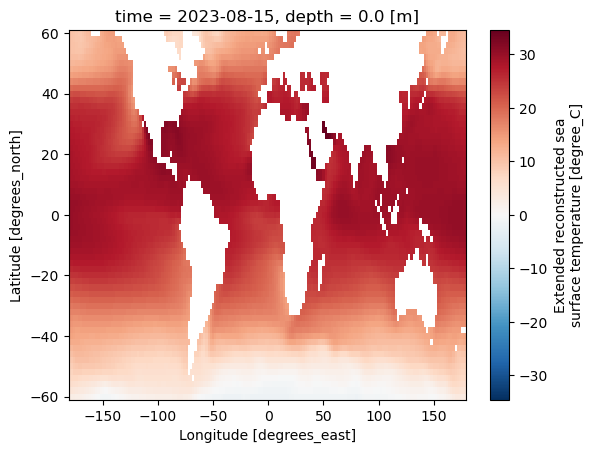

In [8]:
ds.sst.plot()

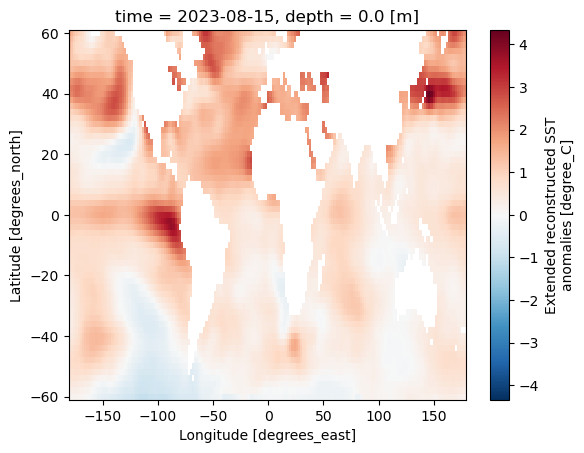

In [9]:
ds.ssta.plot()

## Preprocess data
With the help of the Xarray, we can also performed a quick zonal average of the variable `sst` to see the latitudinal distribution of the sea surface temperature

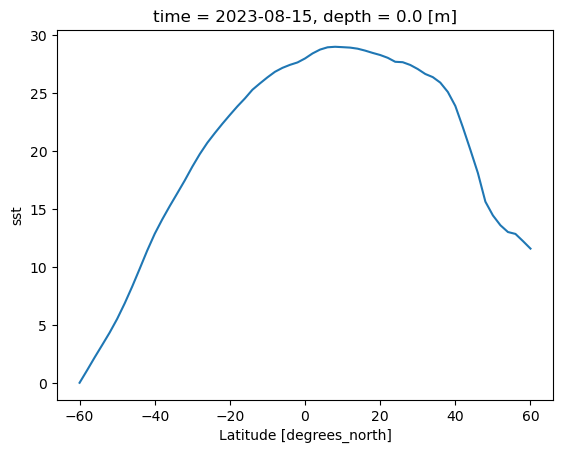

In [10]:
ds.sst.mean(dim='longitude').plot()

The `.mean(dim='longitude')` is the method Xarray provide for zonal averaging.

## Export to netCDF
To output the dataset, we use the `.to_netcdf()` method
```
ds.to_netcdf('./nceiErsstv5_LonPM180.nc')
```